In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import gc

from os import path
import sys
sys.path.append(path.abspath('..'))

In [26]:
import os
import pandas as pd
import cv2
import numpy as np
import torch
from PIL import Image
from tqdm.notebook import tqdm
import seaborn as sns
from timm import create_model

from src.transforms import PadResizeOCR, get_transforms
from src.dataset import PlatesCodeDataset
import jpeg4py as jpeg
import matplotlib.pyplot as plt

from typing import Optional, Tuple
from numpy.typing import NDArray
from torch import Tensor
import albumentations as albu
from torch.utils.data import DataLoader, Dataset, RandomSampler

import random
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [21]:
def denormalize(
    img: NDArray[float],
    mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
    std: Tuple[float, ...] = (0.229, 0.224, 0.225),
    max_value: int = 255,
) -> NDArray[int]:
    denorm = albu.Normalize(
        mean=[-me / st for me, st in zip(mean, std)],  # noqa: WPS221
        std=[1.0 / st for st in std],
        always_apply=True,
        max_pixel_value=1.0,
    )
    denorm_img = denorm(image=img)['image'] * max_value
    return denorm_img.astype(np.uint8)

def tensor_to_cv_image(tensor: Tensor) -> NDArray[float]:
    return tensor.permute(1, 2, 0).cpu().numpy()

def text_decode(
        text_vector: Tensor,
        vocabular: str
) -> str:
    text_vector = text_vector.cpu().numpy()
    text_list = [vocabular[x-1] for x in text_vector if x > 0]
    return ''.join(text_list)

In [22]:
DATA_PATH='../data/'
VOCAB = '#&0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÄÅÖÜĆČĐŠŽБГДЗИЛПУЦЧЭЯ'


(63, 212, 3)

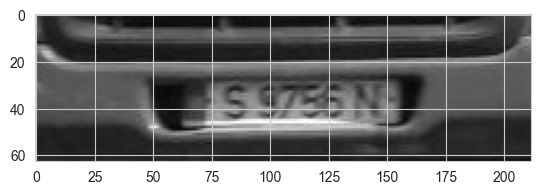

In [4]:
image = jpeg.JPEG('/home/dmitriy/Nextcloud/Projects/Proj_courses/DeepSchool/hw-02/model_plate-ocr/data/dataset-plates/kg/test/8074200.jpg').decode()
image.shape
plt.imshow(image)

### Готовим данные

In [5]:
# создаём датасет
DATA_FOLDER = '../data'

train_dataset = PlatesCodeDataset(
    phase='train', 
    data_folder=DATA_FOLDER,
    reset_flag=True
)
print('\n\n')
valid_dataset = PlatesCodeDataset(
    phase='test', 
    data_folder=DATA_FOLDER,
    reset_flag=True
)

Parse file meta_abh_ref, 1 / 28


Images: 100%|██████████| 3989/3989 [00:35<00:00, 113.86it/s]


Parse file meta_am_ref, 2 / 28


Images: 100%|██████████| 13389/13389 [01:53<00:00, 118.39it/s]


Parse file meta_at_ref, 3 / 28


Images: 100%|██████████| 14044/14044 [02:05<00:00, 112.24it/s]


Parse file meta_az_ref, 4 / 28


Images: 100%|██████████| 3381/3381 [00:29<00:00, 116.02it/s]


Parse file meta_bg_ref, 5 / 28


Images: 100%|██████████| 12539/12539 [01:51<00:00, 112.80it/s]


Parse file meta_by_ref, 6 / 28


Images:   0%|          | 418/197312 [00:03<27:16, 120.31it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 12145671.jpg


Images:   1%|          | 1208/197312 [00:09<24:57, 130.95it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by98319.jpg


Images:   4%|▍         | 8005/197312 [01:05<24:09, 130.63it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 10533431.jpg


Images:   4%|▍         | 8033/197312 [01:05<24:14, 130.18it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 10532575.jpg


Images:   8%|▊         | 15677/197312 [02:07<29:11, 103.69it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by148890.jpg


Images:   8%|▊         | 15978/197312 [02:10<23:27, 128.79it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 8577120.jpg


Images:  12%|█▏        | 22827/197312 [03:08<23:08, 125.69it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by38786.jpg


Images:  14%|█▍        | 27662/197312 [03:49<24:27, 115.60it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by93288.jpg


Images:  14%|█▍        | 27845/197312 [03:50<23:41, 119.22it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by146647.jpg


Images:  24%|██▍       | 47500/197312 [06:36<20:21, 122.63it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by143045.jpg


Images:  26%|██▌       | 50967/197312 [07:06<18:14, 133.66it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by88915.jpg


Images:  26%|██▌       | 51469/197312 [07:10<20:48, 116.78it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 11892601.jpg


Images:  34%|███▍      | 67541/197312 [09:26<19:14, 112.43it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by139155.jpg


Images:  35%|███▍      | 68371/197312 [09:34<21:39, 99.20it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by138931.jpg


Images:  38%|███▊      | 75867/197312 [10:37<21:13, 95.35it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 11758857.jpg


Images:  44%|████▎     | 85873/197312 [12:04<14:46, 125.75it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 7792395.jpg


Images:  44%|████▍     | 86590/197312 [12:10<19:30, 94.62it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 10036729.jpg


Images:  52%|█████▏    | 102356/197312 [14:24<14:04, 112.40it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 20398.jpg


Images:  62%|██████▏   | 122852/197312 [17:28<09:45, 127.25it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 14925.jpg


Images:  65%|██████▌   | 128946/197312 [18:25<10:07, 112.58it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 13461.jpg


Images:  72%|███████▏  | 141820/197312 [20:23<07:44, 119.41it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by178775.jpg


Images:  76%|███████▌  | 150145/197312 [21:38<06:54, 113.80it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 7329.jpg


Images:  77%|███████▋  | 152766/197312 [22:01<05:59, 123.88it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 9611704.jpg


Images:  82%|████████▏ | 162680/197312 [23:29<05:42, 101.00it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 11397654.jpg


Images:  87%|████████▋ | 171887/197312 [24:53<03:37, 117.01it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 9278248.jpg


Images:  90%|█████████ | 178369/197312 [25:52<02:42, 116.59it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by56346.jpg


Images:  98%|█████████▊| 193436/197312 [28:21<00:40, 96.72it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by104220.jpg


Images:  99%|█████████▊| 194490/197312 [28:31<00:26, 105.70it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by103866.jpg


Images: 100%|██████████| 197312/197312 [29:01<00:00, 113.31it/s]


Parse file meta_cz_ref, 7 / 28


Images: 100%|██████████| 17209/17209 [02:57<00:00, 97.07it/s] 


Parse file meta_de_ref, 8 / 28


Images: 100%|██████████| 81455/81455 [14:18<00:00, 94.84it/s] 


Parse file meta_ee_ref, 9 / 28


Images: 100%|██████████| 7789/7789 [01:27<00:00, 89.50it/s] 


Parse file meta_fi_ref, 10 / 28


Images: 100%|██████████| 2952/2952 [00:34<00:00, 85.92it/s]


Parse file meta_ge_ref, 11 / 28


Images:   4%|▍         | 350/9096 [00:03<01:25, 102.66it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 10378938.jpg


Images:  24%|██▍       | 2210/9096 [00:24<01:07, 101.61it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 11091322.jpg


Images:  50%|████▉     | 4508/9096 [00:49<00:49, 92.40it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, 12719050.jpg


Images: 100%|██████████| 9096/9096 [01:39<00:00, 91.28it/s] 


Parse file meta_hu_ref, 12 / 28


Images: 100%|██████████| 97267/97267 [18:55<00:00, 85.69it/s] 


Parse file meta_kg_ref, 13 / 28


Images: 100%|██████████| 7237/7237 [01:23<00:00, 87.02it/s] 


Parse file meta_kz_ref, 14 / 28


Images: 100%|██████████| 27348/27348 [05:26<00:00, 83.69it/s] 


Parse file meta_lt_ref, 15 / 28


Images: 100%|██████████| 12420/12420 [02:37<00:00, 79.10it/s]


Parse file meta_lv_ref, 16 / 28


Images: 100%|██████████| 11338/11338 [02:22<00:00, 79.72it/s]


Parse file meta_md_ref, 17 / 28


Images: 100%|██████████| 13346/13346 [02:36<00:00, 85.28it/s]


Parse file meta_mgl_ref, 18 / 28


Images: 100%|██████████| 402/402 [00:04<00:00, 95.23it/s] 


Parse file meta_pl_ref, 19 / 28


Images: 100%|██████████| 49248/49248 [10:10<00:00, 80.66it/s]


Parse file meta_ro_ref, 20 / 28


Images: 100%|██████████| 9761/9761 [02:06<00:00, 77.23it/s]


Parse file meta_rs_ref, 21 / 28


Images: 100%|██████████| 6101/6101 [01:20<00:00, 75.50it/s]


Parse file meta_rso_ref, 22 / 28


Images: 100%|██████████| 446/446 [00:05<00:00, 82.08it/s]


Parse file meta_rus_ref, 23 / 28


Images:   3%|▎         | 12280/467204 [02:30<1:27:38, 86.51it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20180224_150112_939_1218332.jpg


Images:  12%|█▏        | 55194/467204 [11:14<1:25:25, 80.38it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7035_20170208_111120_516_2462942.jpg


Images:  14%|█▎        | 63969/467204 [13:02<1:24:18, 79.71it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7102_20170217_160126_133_3262316.jpg


Images:  22%|██▏       | 102862/467204 [21:01<1:17:15, 78.60it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6056_20171003_190726_185_35603.jpg


Images:  23%|██▎       | 108332/467204 [22:08<1:15:40, 79.03it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20170819_155510_953_1627137.jpg


Images:  27%|██▋       | 128325/467204 [26:14<1:05:03, 86.81it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20180108_105831_830_825529.jpg


Images:  27%|██▋       | 128442/467204 [26:15<1:03:45, 88.56it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7067_20170102_120257_856_4336629.jpg


Images:  40%|███▉      | 185314/467204 [38:01<59:01, 79.59it/s]  

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_140_20170131_104825_146_2263588.jpg


Images:  45%|████▌     | 211811/467204 [43:31<50:37, 84.07it/s]  

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6124_20170506_124643_790_1223330.jpg


Images:  51%|█████▏    | 239598/467204 [49:18<49:24, 76.77it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7078_20170216_061023_321_1336536.jpg


Images:  55%|█████▌    | 258836/467204 [53:17<40:54, 84.90it/s]  

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_367_20170316_134034_076_1540762.jpg


Images:  62%|██████▏   | 291001/467204 [1:00:03<37:11, 78.95it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6124_20170217_154807_215_1078596.jpg


Images:  63%|██████▎   | 295067/467204 [1:00:54<35:47, 80.16it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20171225_111440_990_712479.jpg


Images:  65%|██████▌   | 303948/467204 [1:02:45<29:59, 90.70it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7075_20170729_214337_402_129380.jpg


Images:  67%|██████▋   | 314519/467204 [1:04:56<30:37, 83.08it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7035_20170826_091244_621_1807384.jpg


Images:  68%|██████▊   | 318766/467204 [1:05:49<29:32, 83.72it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_140_20180114_065153_594_3701565.jpg


Images:  73%|███████▎  | 342780/467204 [1:10:54<26:26, 78.44it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_367_20180114_052813_669_2405641.jpg


Images:  74%|███████▍  | 345583/467204 [1:11:33<26:11, 77.40it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7078_20170222_180605_218_1346731.jpg


Images:  78%|███████▊  | 363271/467204 [1:15:23<21:20, 81.19it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_367_20170813_031010_511_2022830.jpg


Images:  81%|████████  | 376759/467204 [1:18:23<18:54, 79.70it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7067_20170111_063124_529_4350186.jpg


Images:  88%|████████▊ | 412208/467204 [1:26:08<11:23, 80.42it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6004_20180308_131459_948_1160156.jpg


Images:  88%|████████▊ | 413422/467204 [1:26:23<10:38, 84.26it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20180127_131801_305_976697.jpg


Images:  92%|█████████▏| 431589/467204 [1:30:21<07:33, 78.59it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20171225_104109_333_712154.jpg


Images:  96%|█████████▌| 446658/467204 [1:33:36<04:32, 75.51it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6007_20171031_084109_922_258292.jpg


Images:  99%|█████████▊| 460825/467204 [1:36:50<01:20, 79.19it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6106_20171011_221300_186_111760.jpg


Images: 100%|██████████| 467204/467204 [1:38:14<00:00, 79.27it/s]


Parse file meta_rus_tl_ref, 24 / 28


Images: 100%|██████████| 27752/27752 [06:33<00:00, 70.48it/s]


Parse file meta_sk_ref, 25 / 28


Images: 100%|██████████| 10866/10866 [02:22<00:00, 76.36it/s]


Parse file meta_tr_ref, 26 / 28


Images: 100%|██████████| 20428/20428 [04:34<00:00, 74.38it/s]


Parse file meta_ukr_ref, 27 / 28


Images: 100%|██████████| 298321/298321 [1:18:56<00:00, 62.98it/s]


Parse file meta_uz_ref, 28 / 28


Images: 100%|██████████| 4786/4786 [01:18<00:00, 61.19it/s]





Parse file meta_abh_test_ref, 1 / 28


Images: 100%|██████████| 299/299 [00:02<00:00, 115.05it/s]


Parse file meta_am_test_ref, 2 / 28


Images: 100%|██████████| 2678/2678 [00:25<00:00, 103.24it/s]


Parse file meta_at_test_ref, 3 / 28


Images: 100%|██████████| 999/999 [00:09<00:00, 105.85it/s]


Parse file meta_az_test_ref, 4 / 28


Images: 100%|██████████| 298/298 [00:03<00:00, 91.82it/s] 


Parse file meta_bg_test_ref, 5 / 28


Images: 100%|██████████| 999/999 [00:09<00:00, 103.01it/s]


Parse file meta_by_test_ref, 6 / 28


Images:  21%|██        | 4256/20175 [00:36<02:05, 126.81it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by64781.jpg


Images:  40%|████      | 8116/20175 [01:09<01:35, 126.45it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by63981.jpg


Images:  40%|████      | 8129/20175 [01:09<01:41, 118.51it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by63952.jpg


Images:  71%|███████   | 14353/20175 [02:03<00:49, 117.38it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, by172007.jpg


Images: 100%|██████████| 20175/20175 [02:53<00:00, 116.27it/s]


Parse file meta_cz_test_ref, 7 / 28


Images: 100%|██████████| 1000/1000 [00:09<00:00, 104.27it/s]


Parse file meta_de_test_ref, 8 / 28


Images: 100%|██████████| 3000/3000 [00:28<00:00, 106.42it/s]


Parse file meta_ee_test_ref, 9 / 28


Images: 100%|██████████| 601/601 [00:05<00:00, 104.49it/s]


Parse file meta_fi_test_ref, 10 / 28


Images: 100%|██████████| 400/400 [00:03<00:00, 101.63it/s]


Parse file meta_ge_test_ref, 11 / 28


Images: 100%|██████████| 999/999 [00:09<00:00, 105.62it/s]


Parse file meta_hu_test_ref, 12 / 28


Images: 100%|██████████| 1000/1000 [00:09<00:00, 103.32it/s]


Parse file meta_kg_test_ref, 13 / 28


Images: 100%|██████████| 600/600 [00:05<00:00, 101.48it/s]


Parse file meta_kz_test_ref, 14 / 28


Images: 100%|██████████| 277/277 [00:02<00:00, 111.90it/s]


Parse file meta_lt_test_ref, 15 / 28


Images: 100%|██████████| 1100/1100 [00:11<00:00, 99.30it/s] 


Parse file meta_lv_test_ref, 16 / 28


Images: 100%|██████████| 1100/1100 [00:10<00:00, 100.53it/s]


Parse file meta_md_test_ref, 17 / 28


Images: 100%|██████████| 999/999 [00:09<00:00, 108.35it/s]


Parse file meta_mgl_test_ref, 18 / 28


Images: 100%|██████████| 132/132 [00:01<00:00, 111.13it/s]


Parse file meta_pl_test_ref, 19 / 28


Images: 100%|██████████| 999/999 [00:09<00:00, 104.32it/s]


Parse file meta_ro_test_ref, 20 / 28


Images: 100%|██████████| 1000/1000 [00:10<00:00, 99.59it/s] 


Parse file meta_rs_test_ref, 21 / 28


Images: 100%|██████████| 400/400 [00:04<00:00, 96.08it/s] 


Parse file meta_rso_test_ref, 22 / 28


Images: 100%|██████████| 50/50 [00:00<00:00, 107.45it/s]


Parse file meta_rus_test_ref, 23 / 28


Images:   5%|▍         | 5534/116801 [00:50<14:47, 125.35it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6119_20170225_064031_788_2145635.jpg


Images:  19%|█▉        | 22299/116801 [03:25<16:41, 94.36it/s] 

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7035_20170113_110142_402_2166015.jpg


Images:  27%|██▋       | 31807/116801 [04:51<12:56, 109.41it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6106_20170929_192832_629_41704.jpg


Images:  28%|██▊       | 32234/116801 [04:55<13:50, 101.87it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6124_20170225_043840_099_1091400.jpg


Images:  36%|███▌      | 42225/116801 [06:27<11:20, 109.60it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6069_20171027_131252_971_101890.jpg


Images:  40%|███▉      | 46256/116801 [07:04<10:01, 117.35it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6104_20170922_235832_368_5306.jpg


Images:  84%|████████▎ | 97692/116801 [14:57<02:41, 118.08it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_6062_20171226_040947_393_674986.jpg


Images:  87%|████████▋ | 101917/116801 [15:36<02:09, 115.04it/s]

Error: tjDecompressHeader2() failed with error -1 and error string tj3DecompressHeader(): Invalid argument, img_7059_20170220_081325_446_865002.jpg


Images: 100%|██████████| 116801/116801 [17:53<00:00, 108.81it/s]


Parse file meta_rus_tl_test_ref, 24 / 28


Images: 100%|██████████| 3000/3000 [00:30<00:00, 97.00it/s] 


Parse file meta_sk_test_ref, 25 / 28


Images: 100%|██████████| 1000/1000 [00:09<00:00, 104.09it/s]


Parse file meta_tr_test_ref, 26 / 28


Images: 100%|██████████| 1999/1999 [00:20<00:00, 98.51it/s] 


Parse file meta_ukr_test_ref, 27 / 28


Images: 100%|██████████| 26032/26032 [04:12<00:00, 102.94it/s]


Parse file meta_uz_test_ref, 28 / 28


Images: 100%|██████████| 568/568 [00:04<00:00, 127.27it/s]


In [6]:
len(valid_dataset)
len(train_dataset)

175879

1281699

In [7]:
# собираем все размеры изображений
train_shapes = []
for i in range(len(train_dataset)):
    train_shapes.append(train_dataset[i][0].shape)
train_shapes = np.array(train_shapes)

valid_shapes = []
for i in range(len(valid_dataset)):
    valid_shapes.append(valid_dataset[i][0].shape)
valid_shapes = np.array(valid_shapes)


JPEGRuntimeError: tjDecompressHeader2() failed with error -1 and error string Not a JPEG file: starts with 0x31 0x00

### Подбираем высоту

In [8]:
# смотрим статистики и распределения высот
np.median(train_shapes[:, 0])
_ = sns.distplot(train_shapes[:, 0])

np.median(valid_shapes[:, 0])
_ = sns.distplot(valid_shapes[:, 0])

TypeError: list indices must be integers or slices, not tuple

140.0

140.0

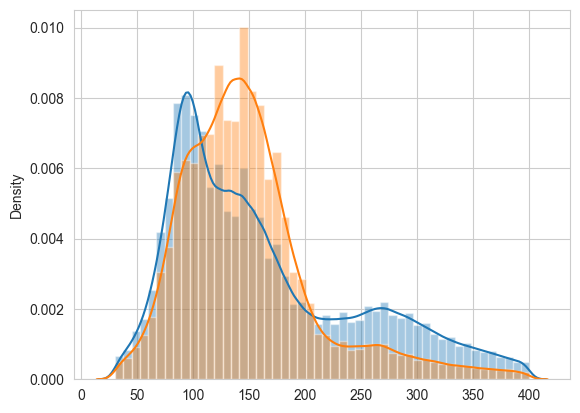

In [87]:
# смотрим статистики и распределения высот
np.median(train_shapes[:, 1])
_ = sns.distplot(train_shapes[:, 1])

np.median(valid_shapes[:, 1])
_ = sns.distplot(valid_shapes[:, 1])

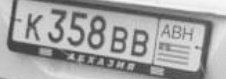

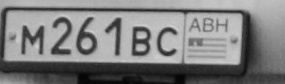

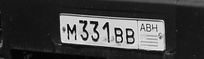

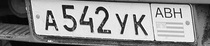

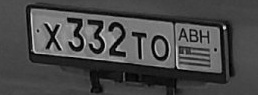

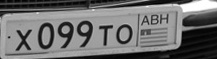

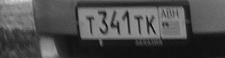

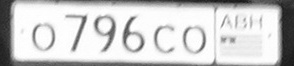

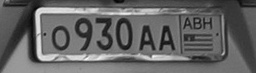

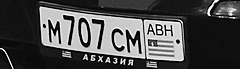

In [88]:
# Посмотрим на оригинальные кропы
for i in range(10):
    Image.fromarray(train_dataset[i][0])

Видно, что высота нормальная, для стандартизации используем 64 (желательно, чтобы делилось на 32 - будем использовать претрен бекбон).

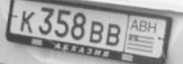

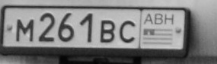

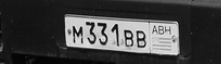

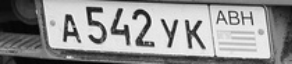

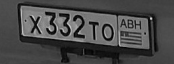

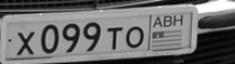

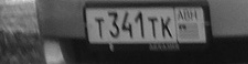

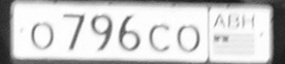

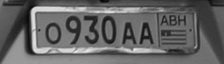

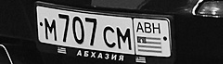

In [89]:
for i in range(10):
    image = train_dataset[i][0]
    scale = 64 / image.shape[0]
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale)
    Image.fromarray(scaled_image)

Отлично, всё видно при высоте 64. 

Всомним из лекции, что для задачи OCR лучше всего делать ресайз с сохранением отношения сторон, а пустоту заполнять нулями. Для этого подберём ширину.

### Подбираем ширину

1109.3333333333333

713.1428571428571

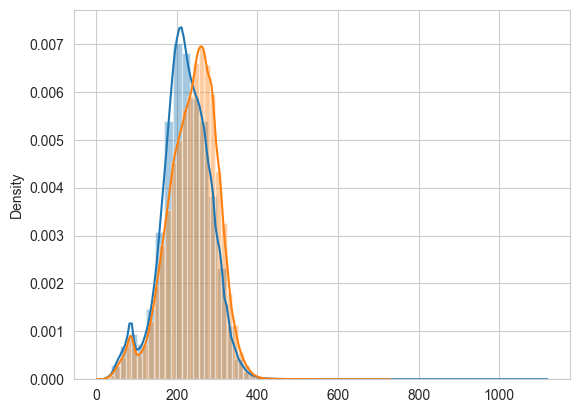

In [90]:
train_width = train_shapes[:, 1] * 64/train_shapes[:, 0]
valid_width = valid_shapes[:, 1] * 64/valid_shapes[:, 0]

np.max(train_width)
_ = sns.distplot(train_width)

np.max(valid_width)
_ = sns.distplot(valid_width)

Ширину же выбираем по максимальному значению + некоторый запас для будущих кропов. Например, здесь имеем 1109 максимум. Но судя по всему это выбросы и длину можно взять с запасом до 416 (чтобы тоже делилось на 32). Проверим

1109.3333333333333


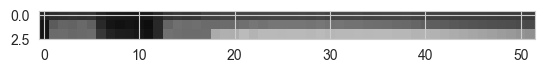

In [115]:
print(max(train_width))
plt.imshow(Image.fromarray(train_dataset[np.argmax(train_width)][0]))

In [113]:
train_shapes[:, 1]

array([226, 285, 204, ...,  74,  48,  82])

390.0952380952381
32
2688


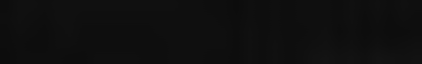

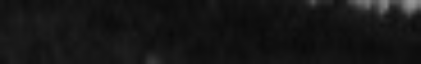

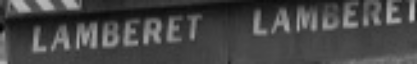

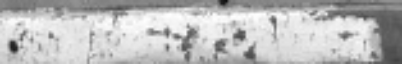

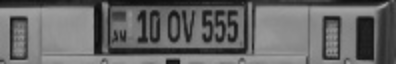

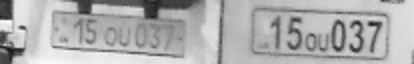

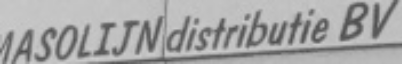

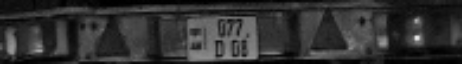

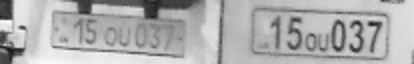

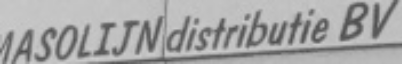

In [120]:
_selected = np.array(train_dataset.image_paths)[train_width > 390]
print(min(train_width[train_width > 390]))
print(min(train_shapes[:, 1][train_width > 390]))
print(len(_selected))
for i in range(10):
    image_path = _selected[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = 64 / image.shape[0]
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale)
    Image.fromarray(scaled_image)

15.058823529411764


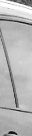

In [102]:
print(min(train_width))
Image.fromarray(train_dataset[np.argmin(train_width)][0])

4822


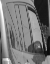

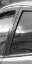

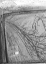

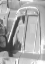

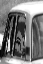

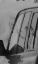

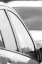

In [109]:
_selected = np.array(train_dataset.image_paths)[train_width < 50]
print(len(_selected))
for i in range(10):
    image_path = _selected[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    scale = 64 / image.shape[0]
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale)
    Image.fromarray(scaled_image)

Таким образом при ресайзе в 64 пикселя по высоте граничными условиями по ширине будут являться изображения [50, 390]

### Смотрим результирующие кропы

Осталось добить изображение падингами и можно скармливать сети!

Самому эту трансформацию реализовывать не нужно. Будем использовать готовую: *PadResizeOCR*.

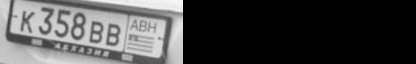

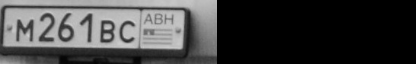

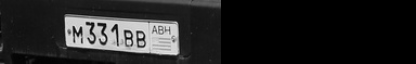

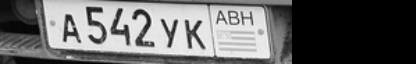

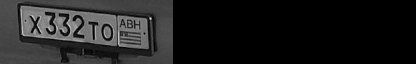

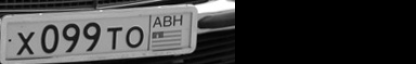

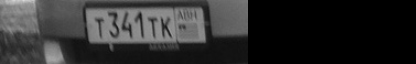

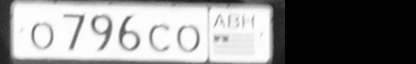

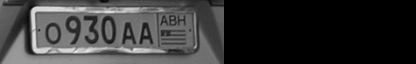

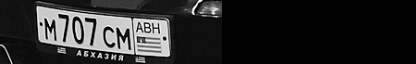

In [110]:
transform = PadResizeOCR(target_width=416, target_height=64, mode='left')

for i in range(10):
    image = train_dataset[i][0]
    transformed_image = transform(image=image)['image']
    Image.fromarray(transformed_image)

Отлично! Это то, что мы и хотели увидеть. Такое не стыдно и сети показать!

### Выбор бекбона

Важным моментом при выборе бекбона будет ширина результирующей фичемапы, т.е. количество тех самых "колбасок" с лекции.
Обычно рекомендуют 2-3 "колбаски" на символ.

Т.е. у нас максимальное количество символов 10, максимальная ширина 390: 390 / (10 * 3) = 13.00 пикселей в "колбаске", округлим до 13.  
Но мы взяли ширину с запасом в 416, а значит в результирующей фичемапе должно быть не меньше 32 колбасок (416 / 13 = 32.0)



In [111]:
# посмотрим какие размеры фичемап получаются на выходе после каждого слоя
backbone = create_model(
            'resnet18',
            pretrained=True,
            features_only=True,
            out_indices=(1,2,3,4),
        )

with torch.no_grad():
    pred = backbone(torch.rand(1, 3, 64, 416))

pred[0].shape
pred[1].shape
pred[2].shape
pred[3].shape


torch.Size([1, 64, 16, 104])

torch.Size([1, 128, 8, 52])

torch.Size([1, 256, 4, 26])

torch.Size([1, 512, 2, 13])

Мы хотим взять фичи с более поздних слоёв, удовлетворяющих нашим критериям:  
4 слой, ширина 13 - мало  
3 слой, ширина 26 - можно попробовать обучиться, но, скорее всего, будет не так хорошо как хотелось бы  
2 слой, ширина 52 - а вот это уже то, что нужно (32 меньше 52!)  
1 слой, ширина 104 - тут уже слишком много, да и какие там фичи с первого слоя  

Если очень хочется брать бекбон с более глубокими слоями, то можно брать готовую сетку и заменить в ней пару страйдов на (2, 1), вместо (2,2).
Ведь именно страйды обычно съедают всю ширину.

Отлично! Мы подобрали бекбон для нашей сети.  
Для подбора остальных параметров смотри исходный код *CRNN*.
Но если ты используешь такие же размеры изображений как здесь, то подбирать ничего не нужно. Всё работает из коробки.

## Проверка кодировки и аугментаций

In [166]:
symbols_non_latin = (
        "АВ5СЕКХНМОРТУ0123456789ӨҮՈ",
        "AB5CEKXHMOPTY0123456789&Y#",
    )

tr_non_latin = {ord(a): ord(b) for a, b in zip(*symbols_non_latin)}

"а551оу750".upper().translate(tr_non_latin)

'A551OY750'

In [167]:
# VOCAB = '#&0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÄÅÖÜĆČĐŠŽАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЭЮЯ'
VOCAB = '#&0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZÄÅÖÜĆČĐŠŽБГДЗИЛПУЦЧЭЯ'

In [168]:
_train_transforms = get_transforms(
    width=416,
    height=64,
    vocab=VOCAB,
    text_size=10,
    postprocessing=True, 
    augmentations=True
)

In [169]:
DATA_FOLDER = '../data'

dataset = PlatesCodeDataset(
    phase='train', 
    data_folder=DATA_FOLDER,
    reset_flag=False,
    transforms=_train_transforms
)

true: text = M909KO34, text_lenght = 8, region = rus


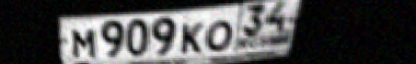

In [175]:
idx = 1000000
image, text, text_lenght, region = dataset[idx]
text_str = text_decode(text, VOCAB)
print(f'true: text = {text_str}, text_lenght = {text_lenght}, region = {region}')

Image.fromarray(denormalize(tensor_to_cv_image(dataset[idx][0])))

## проверка Dataset, dataloader

In [27]:
_train_transforms = get_transforms(
    width=416,
    height=64,
    vocab=VOCAB,
    text_size=10,
)
_valid_transforms = get_transforms(
    width=416,
    height=64,
    vocab=VOCAB,
    text_size=10,
    augmentations=False,
)

In [28]:

train_dataset = PlatesCodeDataset(
    phase='train',
    data_folder=DATA_PATH,
    reset_flag=False,
    transforms=_train_transforms,
)
valid_dataset = PlatesCodeDataset(
    phase='test',
    data_folder=DATA_PATH,
    reset_flag=False,
    transforms=_valid_transforms,
)

num_iterations = 100
batch_size = 16
if num_iterations != -1:
    train_sampler = RandomSampler(
        data_source=train_dataset,
        num_samples=num_iterations * batch_size,
    )

In [29]:
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    num_workers=10,
    sampler=train_sampler,
    shuffle=False if train_sampler else True,
    pin_memory=True,
)

valid_dl = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    num_workers=10,
    shuffle=False,
    pin_memory=True,
)

Selected index 494617 from 1281699. Image: pl18708.jpg
true: text = OST2L26, text_lenght = 7, region = pl


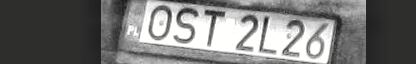


Selected index 100616 from 175879. Image: img_6007_20170914_063308_677_1890710.jpg
true: text = B281TC39, text_lenght = 8, region = rus


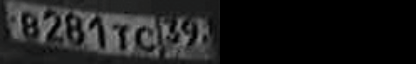

In [35]:
# Test dataset
for _test_dataset in [train_dataset, valid_dataset]:
    random_i = random.randint(0, _test_dataset.__len__() - 1)
    print(
        f"Selected index {random_i} from {_test_dataset.__len__()}. Image: {_test_dataset.image_paths[random_i]}"
    )
    
    image, text, text_lenght, region = _test_dataset[random_i]
    text_str = text_decode(text, VOCAB)
    print(f'true: text = {text_str}, text_lenght = {text_lenght}, region = {region}')
    
    Image.fromarray(denormalize(tensor_to_cv_image(_test_dataset[random_i][0])))
    print()

process
true: text = T268YA163, text_lenght = 9, region = rus


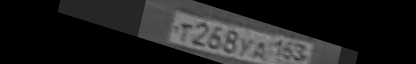


process
true: text = M431CM, text_lenght = 6, region = abh


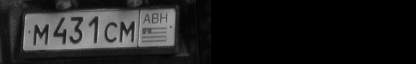

In [38]:
# Test dataloader
for _test_dataloader in [train_dl, valid_dl]:
    print('process')
    images, texts, text_lenghts, regions = next(iter(_test_dataloader))
    text_str = text_decode(texts[0], VOCAB)
    print(f'true: text = {text_str}, text_lenght = {text_lenghts[0]}, region = {regions[0]}')
    
    Image.fromarray(denormalize(tensor_to_cv_image(images[0])))
    print()